In [26]:
# Importing Libraries
import pandas as pd
from pandas import read_csv
from pandas import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Loading global stock price data for exxon mobil
global_stock_exxon = pd.read_csv('final_global_stock_price_for_exxon.csv',index_col='Date',parse_dates=True)
global_stock_exxon.sort_index(inplace = True)
global_stock_exxon_start_date = global_stock_exxon.index[0]
global_stock_exxon_end_date = global_stock_exxon.index[-1]

## APPLE MOBILITY DATA PREPARATION FOR TRAINING WITH STOCK PRICE VALUE

In [3]:
# Loading the Apple Mobility Data and retrieving the segment of use
apple_mobility_data = pd.read_csv('new_apple_final.csv',index_col='Date',parse_dates=True)
apple_mobility_data.sort_index(inplace = True)
apple_mobility_data.drop(apple_mobility_data.filter(regex="Unname"),axis=1, inplace=True)
apple_mobility_data_segment = apple_mobility_data[global_stock_exxon_start_date:global_stock_exxon_end_date]
apple_mobility_data_segment_start_date = apple_mobility_data_segment.index[0]
apple_mobility_data_segment_end_date = apple_mobility_data_segment.index[-1]

In [4]:
# Using Rolling Mean to handle the NaN values present in the data
for j in range(6):
    for i in apple_mobility_data_segment.columns:
        apple_mobility_data_segment['{}_Avg'.format(i)] = apple_mobility_data_segment[i].rolling(5,min_periods = 1,center = True).mean()
        for j in apple_mobility_data_segment.index:
            if np.isnan(apple_mobility_data_segment[i][j]):
                apple_mobility_data_segment[i][j] = apple_mobility_data_segment['{}_Avg'.format(i)][j]
        apple_mobility_data_segment = apple_mobility_data_segment.drop(columns = ['{}_Avg'.format(i)])

In [5]:
# Creating the segment of stock data such that both the data are in same timeframe 
stock_data_exxon_segment = global_stock_exxon[apple_mobility_data_segment_start_date:apple_mobility_data_segment_end_date]

In [6]:
# Creating final data that is used for training the model which gives the impact of Apple Mobility Data on Stock Price Value
combined_column_list = []
for i in apple_mobility_data_segment.columns:
    combined_column_list.append(i)
for i in stock_data_exxon_segment.columns:
    combined_column_list.append(i)

In [7]:
# Creating Joint data of Apple Mobility and Stock Price Value
mobility_vs_stock_exxon_data = pd.DataFrame()
for i in combined_column_list:
    if i == 'Value':
        mobility_vs_stock_exxon_data[i] = stock_data_exxon_segment['Value']        
    elif i == 'Data Present':
        mobility_vs_stock_exxon_data[i] = stock_data_exxon_segment['Data Present']
    else:
        mobility_vs_stock_exxon_data[i] = apple_mobility_data_segment[i]

In [8]:
# Function for Spliting the data into Training-Validation-Testing Data with split ratio as 80-10-10

def train_valid_test_split(dataset):
    tr_size=int((dataset.shape[0])*0.8)
    va_size=int((dataset.shape[0])*0.9)
    train = dataset[:tr_size]
    validation = dataset[tr_size:va_size]
    test = dataset[va_size:]
    return train,validation,test

In [9]:
# Spliting the data into Training-Validation-Testing Data with split ratio as 80-10-10
train, validation, test = train_valid_test_split(mobility_vs_stock_exxon_data)

In [10]:
# Getting the trainable features and label from the actual data

# Training Set
train_X = train.drop(columns=['Value'])
train_y = train['Value']

# Validation Set
validation_X = validation.drop(columns=['Value'])
validation_y = validation['Value']

# Testing Set
test_X = test.drop(columns=['Value'])
test_y = test['Value']

## Training LinearRegression Model to get linear impact of Apple Mobility on Stock Price of Exxon

In [11]:
# Importing LinearRegression Model from sklearn
from sklearn.linear_model import LinearRegression

In [12]:
# Creating and Fitting the linear model on Training Set of the data
linear_model = LinearRegression()
linear_model.fit(train_X,train_y)

LinearRegression()

In [13]:
# Predicting the stock price value for exxon using linear model
pred_train_y = linear_model.predict(train_X)
pred_valid_y = linear_model.predict(validation_X)
pred_test_y = linear_model.predict(test_X)

In [14]:
# Using Root Mean Squared Error Metrics for Model Evaluation
from sklearn.metrics import mean_squared_error

rmse_train = np.sqrt(mean_squared_error(train_y,pred_train_y))
rmse_valid = np.sqrt(mean_squared_error(validation_y,pred_valid_y))
rmse_test = np.sqrt(mean_squared_error(test_y,pred_test_y))

rmse_train,rmse_valid,rmse_test

(2.0542011901460997, 3.1452857622226276, 5.058692976686699)

In [15]:
#Creating the target vs prediction dataframe for each set of data for linear model

train_result = pd.DataFrame()
train_result['target'] = train_y
train_result['predicted']=pred_train_y
train_result.to_csv('linear_model_train_result.csv')

validation_result = pd.DataFrame()
validation_result['target'] = validation_y
validation_result['predicted']=pred_valid_y
validation_result.to_csv('linear_model_validation_result.csv')

test_result = pd.DataFrame()
test_result['target'] = test_y
test_result['predicted']=pred_test_y
test_result.to_csv('linear_model_test_result.csv')


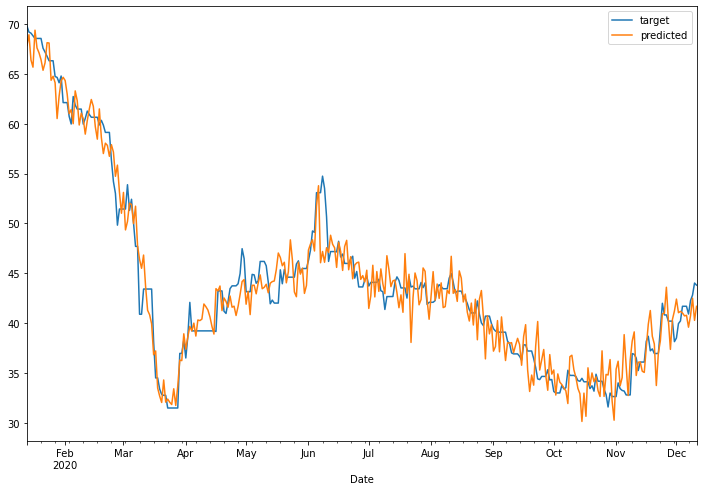

In [16]:
# Plotting the fit of prediction to the target of training data for linear model
train_result[['target','predicted']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

## Getting the feature importance of Apple Mobility Data using Permutation_Importance by Sklearn for Linear Model

In [17]:
from sklearn.inspection import permutation_importance

In [18]:
# Knowing the importance of each feature of Apple Mobility Data for linear model

linear = permutation_importance(linear_model,train_X, train_y,n_repeats=30,random_state=43)
for i in linear.importances_mean.argsort()[::-1]:
    if linear.importances_mean[i] - 2 * linear.importances_std[i] > 0:
        print(f"{combined_column_list[i]:<8}"
              f"{linear.importances_mean[i]:.3f}"
              f" +/- {linear.importances_std[i]:.3f}")

UPPER NORMANDY REGION_DRIVING1.213 +/- 0.077
BIRMINGHAM_DRIVING0.911 +/- 0.052
MANILA_TRANSIT0.776 +/- 0.033
ALAMEDA COUNTY_DRIVING0.459 +/- 0.024
ALBANY_WALKING0.270 +/- 0.016
ALBANY_DRIVING0.269 +/- 0.017
ISHIKAWA PREFECTURE_TRANSIT0.241 +/- 0.015
CONTRA COSTA COUNTY_TRANSIT0.229 +/- 0.013
MILWAUKEE_WALKING0.186 +/- 0.015
MIDI-PYR+¬N+¬ES REGION_TRANSIT0.178 +/- 0.014
HONOLULU COUNTY_WALKING0.178 +/- 0.010
ILLINOIS_WALKING0.132 +/- 0.009
ELLIS COUNTY_DRIVING0.129 +/- 0.011
MIAMI_TRANSIT0.118 +/- 0.008
HINDS COUNTY_DRIVING0.099 +/- 0.007
RIVERSIDE COUNTY_TRANSIT0.097 +/- 0.006
BEXAR COUNTY_DRIVING0.091 +/- 0.007
BELFAST_DRIVING0.090 +/- 0.007
RUTHERFORD COUNTY_DRIVING0.078 +/- 0.007
HOKKAIDO (PREFECTURE)_WALKING0.061 +/- 0.005
ANNAPOLIS_WALKING0.058 +/- 0.004
MILWAUKEE_TRANSIT0.057 +/- 0.004
MANCHESTER_DRIVING0.053 +/- 0.005
MIAMI_WALKING0.050 +/- 0.005
RENO COUNTY_DRIVING0.050 +/- 0.004
LYON_DRIVING0.046 +/- 0.005
MANNHEIM_WALKING0.045 +/- 0.004
BIBB COUNTY_DRIVING0.042 +/- 0.004
CONT

## Training RandomForestRegressor Model to get non-linear impact of Apple Mobility on Stock Price of Exxon

In [19]:
# Importing RandomForestRegressor Model from sklearn
from sklearn.ensemble import RandomForestRegressor

In [20]:
# Creating and Fitting the random forest model on Training Set of the data
rf_model = RandomForestRegressor()
rf_model.fit(train_X,train_y)

RandomForestRegressor()

In [21]:
# Predicting the stock price value for exxon using random forest model
pred_train_y_rf = rf_model.predict(train_X)
pred_valid_y_rf = rf_model.predict(validation_X)
pred_test_y_rf = rf_model.predict(test_X)

In [22]:
# Using Root Mean Squared Error Metrics for Model Evaluation

rmse_train_rf = np.sqrt(mean_squared_error(train_y,pred_train_y_rf))
rmse_valid_rf = np.sqrt(mean_squared_error(validation_y,pred_valid_y_rf))
rmse_test_rf = np.sqrt(mean_squared_error(test_y,pred_test_y_rf))

rmse_train_rf,rmse_valid_rf,rmse_test_rf

(0.7125465265615802, 3.450788006831952, 11.52909931205134)

In [23]:
#Creating the target vs prediction dataframe for each set of data for random forest model

train_result_rf = pd.DataFrame()
train_result_rf['target'] = train_y
train_result_rf['predicted']=pred_train_y_rf
train_result_rf.to_csv('random_forest_model_train_result.csv')

validation_result_rf = pd.DataFrame()
validation_result_rf['target'] = validation_y
validation_result_rf['predicted']=pred_valid_y_rf
validation_result_rf.to_csv('random_forest_model_validation_result.csv')

test_result_rf = pd.DataFrame()
test_result_rf['target'] = test_y
test_result_rf['predicted']=pred_test_y_rf
test_result_rf.to_csv('random_forest_model_test_result.csv')

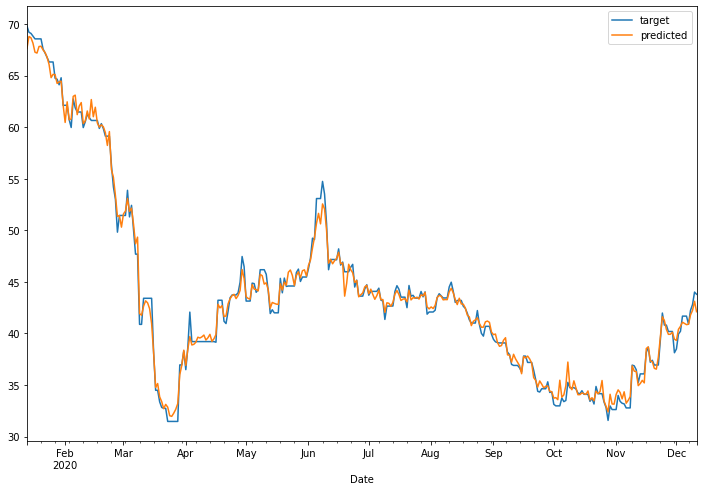

In [24]:
# Plotting the fit of prediction to the target of training data for random forest model
train_result_rf[['target','predicted']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

## Getting the feature importance of Apple Mobility Data using Permutation_Importance by Sklearn for Random Forest Model

In [25]:
# Knowing the importance of each feature of Apple Mobility Data for random forest model

rf = permutation_importance(rf_model,train_X, train_y,n_repeats=30,random_state=43)
for i in rf.importances_mean.argsort()[::-1]:
    if rf.importances_mean[i] - 2 * rf.importances_std[i] > 0:
        print(f"{combined_column_list[i]:<8}"
              f"{rf.importances_mean[i]:.3f}"
              f" +/- {rf.importances_std[i]:.3f}")

MANILA_TRANSIT1.184 +/- 0.060
BERGAMO_WALKING0.085 +/- 0.013
ALBEMARLE COUNTY_WALKING0.043 +/- 0.004
HYOGO PREFECTURE_WALKING0.038 +/- 0.004
AMSTERDAM_TRANSIT0.017 +/- 0.002
HOKKAIDO (PREFECTURE)_WALKING0.017 +/- 0.002
ISHIKAWA PREFECTURE_TRANSIT0.012 +/- 0.001
UPPER NORMANDY REGION_DRIVING0.009 +/- 0.001
MICHOAC+ÍN_DRIVING0.008 +/- 0.001
HALLAND COUNTY_DRIVING0.007 +/- 0.001
BLAINE COUNTY_DRIVING0.006 +/- 0.001
BELO HORIZONTE_WALKING0.006 +/- 0.001
COMAL COUNTY_DRIVING0.005 +/- 0.001
MIDI-PYR+¬N+¬ES REGION_TRANSIT0.004 +/- 0.001
EAGLE COUNTY_WALKING0.002 +/- 0.000
CHAMPAIGN COUNTY_DRIVING0.002 +/- 0.000
RICHMOND COUNTY_DRIVING0.002 +/- 0.000
REDWOOD COUNTY_DRIVING0.001 +/- 0.000
CREEK COUNTY_DRIVING0.001 +/- 0.000
MARLBOROUGH REGION_DRIVING0.001 +/- 0.000
MITO_TRANSIT0.001 +/- 0.000
RENO COUNTY_DRIVING0.001 +/- 0.000
HONOLULU COUNTY_DRIVING0.001 +/- 0.000
HONOLULU COUNTY_WALKING0.001 +/- 0.000
HAYWOOD COUNTY_DRIVING0.001 +/- 0.000
UUSIMAA_TRANSIT0.001 +/- 0.000
ALBANY COUNTY_DRIVING0.